In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import operator
import functools
import scipy.sparse as sp
import itertools
import tqdm.autonotebook as tqdm
import matplotlib.pyplot as plt
plt.style.use("classic")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [317]:
class ScriptParams():
    authors_p = "../input/graph-data/authors.txt.npz"
    train_p = "../input/graph-data/train.csv"
    test_p = '../input/graph-data/test.csv/test.csv'
    adj_p = "../input/graph-data/adj.txt.npz"
    author_emb_p = "../input/graph-data/authors_emb.txt.npz"

In [2]:
def make_df():
    """
    builds the training and testing dataframes.
    """
    authors = np.load(ScriptParams.authors_p)["arr_0"]
    df_train = pd.read_csv(ScriptParams.train_p, dtype={'authorID': np.int64, 'h_index': np.int32})
    df_test = pd.read_csv(ScriptParams.test_p dtype={'authorID': np.int64})
    author_to_index = dict(zip(authors, range(len(authors))))
    
    for df in (df_train, df_test):
        df["idx"] = df["authorID"].map(author_to_index)
    h_index = np.zeros_like(authors, dtype=np.int32)
    h_index[df_train["idx"]] = df_train["h_index"]
    return df_train, df_test, h_index

def normalize(A: sp.csr_matrix, use_self_loops=True, L=1.0):
    """ normalize the adjacency matrix.
    params:
    ------
    use_self_loops:
        add self-loops to the value of lambda (L).
        L can be tuned as a regularization hyper-parameter.
    L: self-loop value. Unused if use_self_loops is False.
    """
    
    if use_self_loops:
        A.setdiag(L)
    
    D = A.sum(axis=0).A1
    D = np.power(D, -0.5)
    D = sp.diags((D),0, format="csr")
    return D.dot(A).dot(D)

def sparse_to_torch_sparse(M):
    """Converts a sparse SciPy matrix to a sparse PyTorch tensor
    (taken from the TPs)"""
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [52]:
class MessagePassing(nn.Module):
    """ A "message passing layer" as in https://arxiv.org/pdf/1609.02907.pdf
    """
    
    def __init__(self, A, in_features, out_features):
        """
        paramters:
        n_in: input features dim
        n_h: hidden features dim
        A: normalized adj.
        """
        super(MessagePassing, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))
        self.A = A
        self._build()
     
    def _build(self):
        gain = nn.init.calculate_gain("relu")
        bound = self.in_features**(-0.5)
        nn.init.xavier_normal_(self.weight)
        nn.init.uniform_(self.bias, a=-bound, b=bound)

    
    def forward(self, x):
        x = torch.mm(x, self.weight)
        x = torch.addmm(self.bias, self.A, x)
        return x
    
    
    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

    
class Model():
    """
    a wrapper around a model and an optimizer to perform training, used for the GCN.
    feeds all the inputs at each step.
    """
    def __init__(self, model, optimizer, loss, x, target, indices, val_percent):
        self.model = model.to(device)
        self.loss = loss
        self.optimizer = optimizer
        self.target = target.to(device)
        self.x = x
        self.saves = list()
        self.saves.append(model.state_dict())
        val_mask = torch.rand(indices.shape).to(device) < val_percent
        self.train_idx = indices[~val_mask].to(torch.long).to(device)
        self.val_idx = indices[val_mask].to(torch.long).to(device)
        self.hist = []
        self.lr_hist = []
        self.scheduler = None
    
    def lr_find(self):
        mul_lr = lambda epoch: 1.5
        self.scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer=self.optimizer, lr_lambda=mul_lr)
        
    
    def train_step(self, ret_cpu = False,):
        self.optimizer.zero_grad(set_to_none=True)
        output = self.model(self.x)
        output = output.reshape((-1, ))
        loss = self.loss(output[self.train_idx], self.target[self.train_idx])
        loss.backward()
        self.optimizer.step()
        if ret_cpu:
            val_loss = self.loss(output[self.val_idx], self.target[self.val_idx])
            #val_l1 = nn.L1Loss()(output[self.val_idx], self.target[self.val_idx])
            return loss.detach().cpu().numpy(), val_loss.detach().cpu().numpy(), None#val_l1.detach().cpu().numpy()
        else:
            return None, None
        
    def fit(self, n, u=50, verbose=True):
        #self.scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, 1.0, total_steps=n, steps_per_epoch=u)
        iter_range = tqdm.trange(n)
        for i in iter_range:
            loss, val_loss, val_l1= self.train_step(ret_cpu=True)
            iter_range.set_postfix_str(f"train:{loss:<8.2f}val:{val_loss:<8.2f}", refresh=False)
            self.hist.append((loss, val_loss))
        return self
    

class SimpleModel():
    """
    a wrapper around a model and an optimizer to perform training, used for the FCN.
    only uses then inputs for which we have a target.
    """
    def __init__(self, model, optimizer, loss, x, target, indices, val_percent):
        self.model = model.to(device)
        self.loss = loss
        self.optimizer = optimizer
        self.target = target.to(device)
        self.x = x
        self.saves = list()
        self.saves.append(model.state_dict())
        val_mask = torch.rand(indices.shape).to(device) < val_percent
        self.train_idx = indices[~val_mask].to(torch.long).to(device)
        self.val_idx = indices[val_mask].to(torch.long).to(device)
        self.x_train = self.x[self.train_idx]
        self.x_val = self.x[self.val_idx]
        self.y_train = self.target[self.train_idx]
        self.y_val = self.target[self.val_idx]
        self.hist = []
        self.lr_hist = []
        self.scheduler = None

    def lr_find(self):
        mul_lr = lambda epoch: 1.5
        self.scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer=self.optimizer, lr_lambda=mul_lr)


    def train_step(self):
        self.optimizer.zero_grad(set_to_none=True)
        output = self.model(self.x_train)
        output = output.reshape((-1, ))
        loss = self.loss(output, self.y_train)
        loss.backward()
        self.optimizer.step()
        with torch.no_grad():
            val_output = self.model(self.x_val)
            val_output = val_output.reshape((-1, ))
            val_loss = self.loss(val_output, self.y_val)

            return loss.detach().cpu().item(), val_loss.detach().cpu().item()

    def fit(self, n, u=50, verbose=True):
        iter_range = tqdm.trange(n)
        for i in iter_range:
            loss, val_loss= self.train_step()
            iter_range.set_postfix_str(f"train:{loss:<8.2f}val:{val_loss:<8.2f}", refresh=False)
            self.hist.append((loss, val_loss))
        return self

In [53]:
df_train, df_test, y_ = make_df()

In [318]:
def make_features(use_embeddings=False):
    """ Builds the simple nodes features: ones, degree, and number_of_papers.
    """
    A = sp.load_npz(ScriptParams.adj_p).astype(np.int)
    ones = np.ones(A.shape[1])
    degree = A @ ones
    degree2 = A @ degree
    number_of_papers = np.load(ScriptParams.author_emb_p)["author_npaper"]
    if use_embeddings:
        embs = np.load(ScriptParams.author_emb_p)["author_embs"]
        return np.concatenate((degree[...,np.newaxis], number_of_papers[...,np.newaxis], embs), axis=1).astype(np.float32)
    else:
        return np.stack((ones, degree, number_of_papers), axis=1).astype(np.float32)

In [239]:
#load the normalized adjacency
B = sparse_to_torch_sparse(normalize(sp.load_npz(ScriptParams.adj_p), use_self_loops=True, L=0.1)).to(device)

In [240]:
#load the features
x = torch.from_numpy(make_features(use_embeddings=False)).to(device)
y = torch.from_numpy(y_).to(torch.float).to(device)
indices = torch.from_numpy(df_train["idx"].to_numpy()).to(device)

In [241]:
# input (idxs, off) to an embeding layer to use learnt embeddings as features.
#off = torch.from_numpy(A.indptr[:-1]).to(torch.long).to(device)
#idxs= torch.from_numpy(A.indices).to(torch.long).to(device)

In [242]:
#load text features
embs = torch.from_numpy(np.load(ScriptParams.author_emb_p)["author_embs"]).to(torch.float).to(device)

In [243]:
#smooth-out text-features.
K = 4
for _ in range(K):
    embs = B @ embs

In [244]:
x = torch.cat((x, embs), axis=1)

In [245]:
class WrappedBag(nn.Module):
    def __init__(self, *args, **argp):
        super(WrappedBag, self).__init__()
        self.eb = nn.EmbeddingBag(*args, **argp)
    
    def forward(self, x):
        return self.eb(*x)
    

In [284]:
n_h = 128
layers = [ # GNC
    MessagePassing(B, x.shape[1], n_h),
    nn.ReLU(),
    MessagePassing(B, n_h, n_h),
    nn.ReLU(),
    MessagePassing(B, n_h, 1),
    ]

if True:

    layers = [ #FCN
        nn.Linear(x.shape[1], n_h),
        nn.ReLU(),
        nn.Linear(n_h, 1)
    ]

gcn = nn.Sequential(*layers).to(device)
loss = nn.L1Loss()
#loss = nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=0.008)
torch.manual_seed(0);
trainer = SimpleModel(gcn, optimizer, loss, x, y.to(torch.long), indices, .1)

In [285]:
trainer.optimizer.param_groups[0]["lr"] = 0.01

  0%|          | 0/500 [00:00<?, ?it/s]

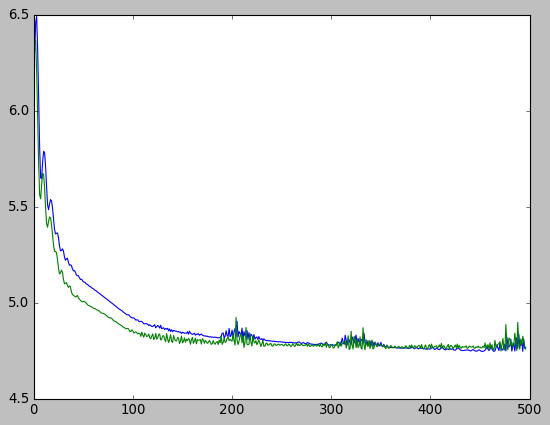

In [286]:
trainer.fit(500, )
plt.plot(trainer.hist[3:])

In [305]:
def make_pred(x, df):
    """
    makes predictions for the h-index using the features x
    """
    features = x[df["idx"]]
    with torch.no_grad():
        out = np.rint(trainer.model(features).cpu().numpy())
    df["h_index_pred"] = out
    return df

In [306]:
preds = make_pred(x, df_test)

In [313]:
preds[["authorID","h_index_pred"]].to_csv("preds.csv", index=False)